# Section 3 – Unsupervised learning – clustering


We chose three clustering algorithms to capture different aspects of the data: k-Means for hard clustering, Gaussian Mixture Model (GMM) for probabilistic soft clustering, and DBSCAN for density-based clustering. This selection provides a more comprehensive analysis than just using two algorithms, as it covers a wider variety of data structures and clustering techniques.


# Library import operations and database loading

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ddos-data/ddos_dataset.csv


In [ ]:
# import needed python libraries

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, rand_score, adjusted_rand_score
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.manifold import TSNE

# read data
ddos_data = pd.read_csv("/kaggle/input/ddos-data/ddos_dataset.csv", sep=",", dtype={'SimillarHTTP': str})
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
columns = ddos_data.columns

# set Flow ID
ddos_data["Flow ID"] = ( ddos_data['Source IP'].astype(str) + ' - ' +
                         ddos_data['Source Port'].astype(str) + ' - ' +
                         ddos_data['Destination IP'].astype(str) + ' - ' +
                         ddos_data['Destination Port'].astype(str) + ' - ' +
                         ddos_data['Timestamp'].astype(str) )
ddos_data = ddos_data.set_index("Flow ID")

#  categorical SimillarHTTP
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].astype(str).str.strip()
ddos_data['SimillarHTTP'] = pd.Categorical(ddos_data['SimillarHTTP']).codes

# delete rubbish
ddos_data.drop("Unnamed: 0", axis=1, inplace=True)

# delete varancie null
variance = ddos_data.var(numeric_only=True)
zero_variance = variance[variance == 0].index
ddos_data.drop(zero_variance, axis=1, inplace=True)

# one-hot encode Protocol
mask_udp = ddos_data['Protocol'] == 0
mask_tcp = ddos_data['Protocol'] == 6
mask_hopopt = ddos_data['Protocol'] == 17
ddos_data['Protocol 0'] = mask_udp.astype(int)
ddos_data['Protocol 6'] = mask_tcp.astype(int)
ddos_data['Protocol 17'] = mask_hopopt.astype(int)

# encode Port
frequencies = ddos_data['Destination Port'].value_counts()
ddos_data['Destination Port Freq'] = ddos_data['Destination Port'].map(frequencies)
frequencies = ddos_data['Source Port'].value_counts()
ddos_data['Source Port Freq'] = ddos_data['Source Port'].map(frequencies)

# delete features
ddos_data.drop(
    columns=["Destination IP", "Source IP", "Source Port", "Destination Port", "Timestamp", "Protocol"],
    axis=1,
    inplace=True)


# features selected in the first section
columns_to_remove = ['Active Max', 'Active Min', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s', 'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Mean', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Protocol 17', 'Protocol 6', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']
ddos_data = ddos_data.drop(columns=columns_to_remove)
ddos_data.columns

# Stratify the dataset by having 70% of the data in the traning set and 30% in the test set

ddos_data_temp = ddos_data.copy()
#ddos_data_temp['label'] = pd.Categorical(ddos_data_temp['label']).codes

X = ddos_data_temp.drop(columns=['label']).to_numpy()
y = ddos_data_temp[['label']]

# Standardize data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)


In [3]:
np.unique(y)

array(['benign', 'ddos_dns', 'ddos_ldap', 'ddos_mssql', 'ddos_netbios',
       'ddos_ntp', 'ddos_snmp', 'ddos_ssdp', 'ddos_syn', 'ddos_tftp',
       'ddos_udp', 'ddos_udp_lag'], dtype=object)

# **k-Means**

## 1. Determine the number of clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kme

best k:  122  with corresponding silhouette:  0.7502081888489263


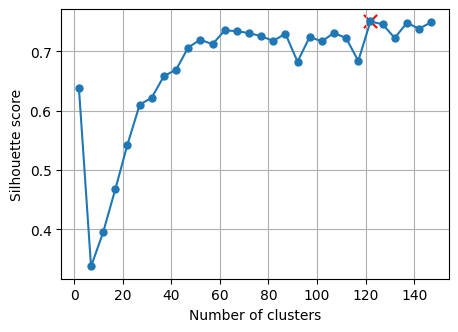

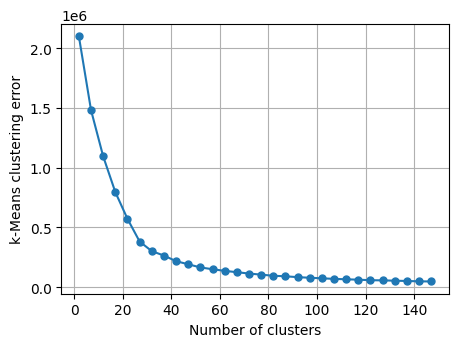

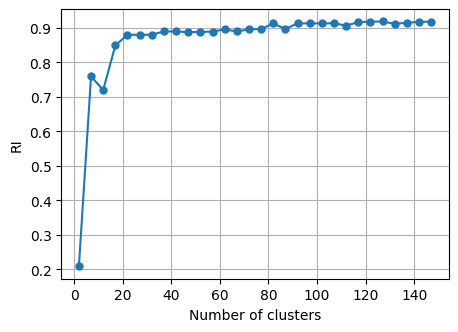

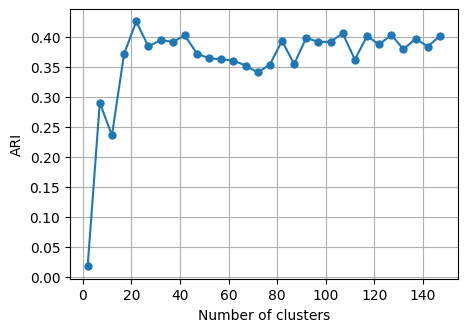

In [4]:
n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
inertia_list=[]

for n_clusters in range(2, 150, 5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cl_labels = kmeans.fit_predict(X_s)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette_score(X_s, cl_labels))
    ri_list.append(rand_score(np.ravel(y), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(y), cl_labels))
    inertia_list.append(kmeans.inertia_)



# Get n_clusters leading to the highest silhouette
best_sh= np.max(shs_list)
best_n=n_cluster_list[np.argmax(shs_list)]
print("best k: ",best_n, " with corresponding silhouette: ", best_sh)

# Plot Silhouette
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Plot k-Means clustering error
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,inertia_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.show()

# Plot RI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ri_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()

In [5]:
# print the clustered and centroid labels
print('The clustered labels are:\n', kmeans.labels_)
centroids = kmeans.cluster_centers_
print('The centroids are:\n', centroids)

The clustered labels are:

 [ 21  63  21 ... 117   0 117]

The centroids are:

 [[-2.92722484e-02 -3.90993760e-01  4.33489021e-01 ... -3.00615076e-02

  -2.83203696e-01 -4.74312236e-01]

 [-3.63720192e-02  9.21469251e-02 -1.72276774e-01 ... -3.00615076e-02

  -2.87890472e-01 -4.06514139e-01]

 [-3.63720192e-02 -9.94830889e-01  2.65847179e-01 ... -3.00615076e-02

   2.97482973e+00 -4.73875833e-01]

 ...

 [-1.16262762e-02 -1.01239760e-03  4.63808290e+00 ... -3.00615076e-02

   2.40096355e+00 -4.64026595e-01]

 [-7.53082686e-03 -1.04832931e+00 -1.72276774e-01 ... -3.00615076e-02

  -2.88560386e-01 -4.74962080e-01]

 [ 2.54245407e-01  4.79589539e-01  3.43824587e+00 ... -3.00615076e-02

   2.97482973e+00 -4.73731992e-01]]


## Applying K-Means

In [6]:
# k-Means with n_clusters = 35
kmeans = KMeans(n_clusters=35, random_state = 0)
cl_labels3 = kmeans.fit_predict(X_s)

# Unsupervised metrics
silhouette = silhouette_score(X_s, cl_labels3)
calinski_harabasz = calinski_harabasz_score(X_s, cl_labels3)
davies_bouldin = davies_bouldin_score(X_s, cl_labels3)

# Supervised metrics
ri = rand_score(np.ravel(y), cl_labels3)
ari = adjusted_rand_score(np.ravel(y), cl_labels3)

print('k-Means with 35 clusters')
(unique, counts) = np.unique(cl_labels3, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'Calinski-Harabasz: {round(calinski_harabasz, 2)}')
print(f'Davies-Bouldin: {round(davies_bouldin, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(


k-Means with 35 clusters

Size of each cluster:  [ 8216 14869  1244   239  7357    27  3396  2016   538   472     1   512

    38     2     5  8441  2125    53  6155     1    37  4366   158    30

  1978   250   196     2   163   283   109     3   129   823     5]

k_means clustering error: 282283.04

Silhouette: 0.65

Calinski-Harabasz: 13581.98

Davies-Bouldin: 0.73

RI: 0.89

ARI: 0.42


## ECDF of number of cluster

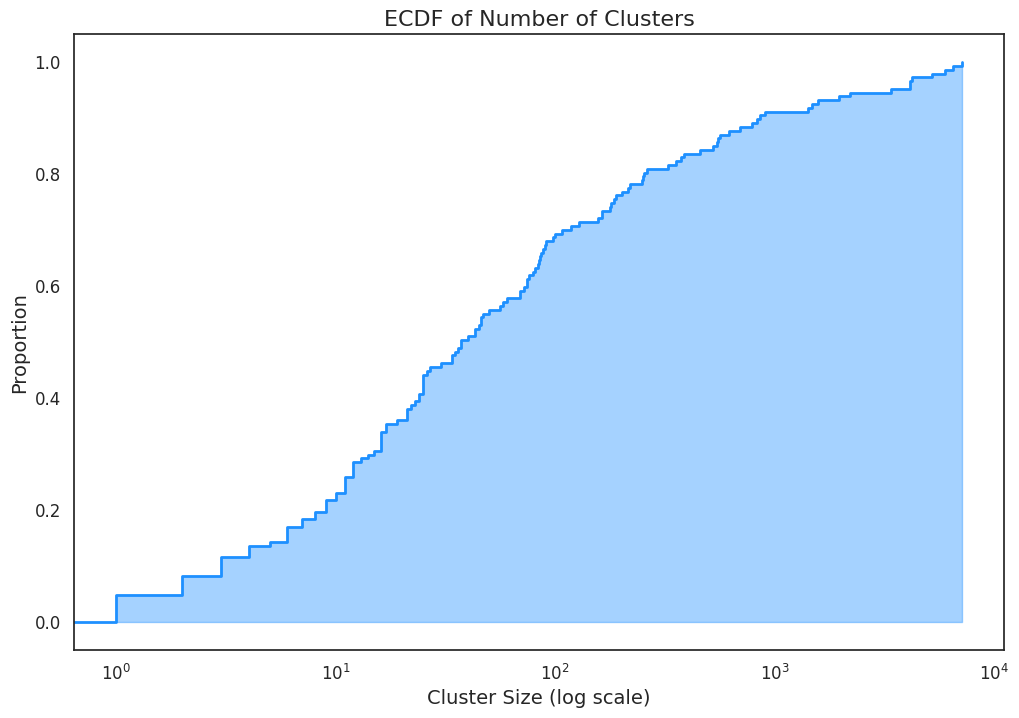

In [7]:
unique, counts = np.unique(cl_labels, return_counts=True)
cluster_sizes = counts
ecdf = ECDF(cluster_sizes)

sns.set(style="white")
plt.figure(figsize=(12, 8))
plt.step(ecdf.x, ecdf.y, where="post", color='dodgerblue', linewidth=2)
plt.fill_between(ecdf.x, ecdf.y, step="post", alpha=0.4, color='dodgerblue')
plt.xscale('log')
plt.xlabel('Cluster Size (log scale)', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('ECDF of Number of Clusters', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## Cluster Visualization

In [3]:
# Dimensionality reduction with t-SNE.
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_s)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(


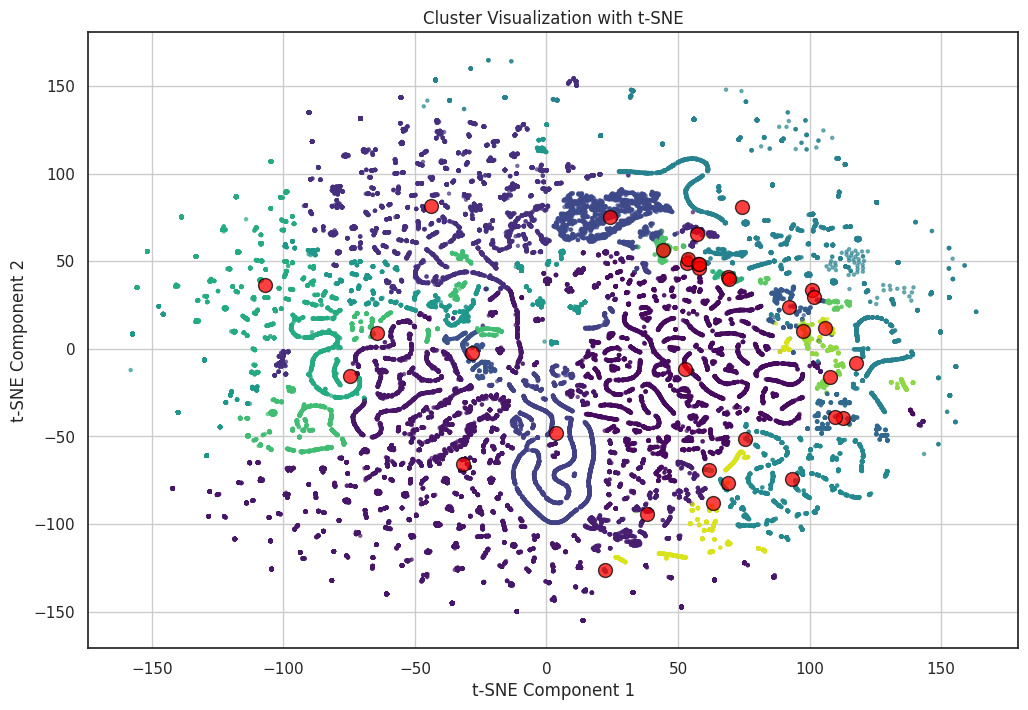

In [9]:
best_n = 35

kmeans = KMeans(n_clusters=best_n, random_state=0)
cl_labels = kmeans.fit_predict(X_s)

# Calculate the position of the centroids
centroids = kmeans.cluster_centers_

# Reducing the dimensionality of centroids with t-SNE.
centroids_tsne = np.array([X_tsne[cl_labels == i].mean(axis=0) for i in range(best_n)])

plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", best_n)  # Utilizza una palette di colori distintiva
colors = [palette[label] for label in cl_labels]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, s=5, alpha=0.6)
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], c='red', s=100, alpha=0.75, edgecolors='black')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization with t-SNE')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(


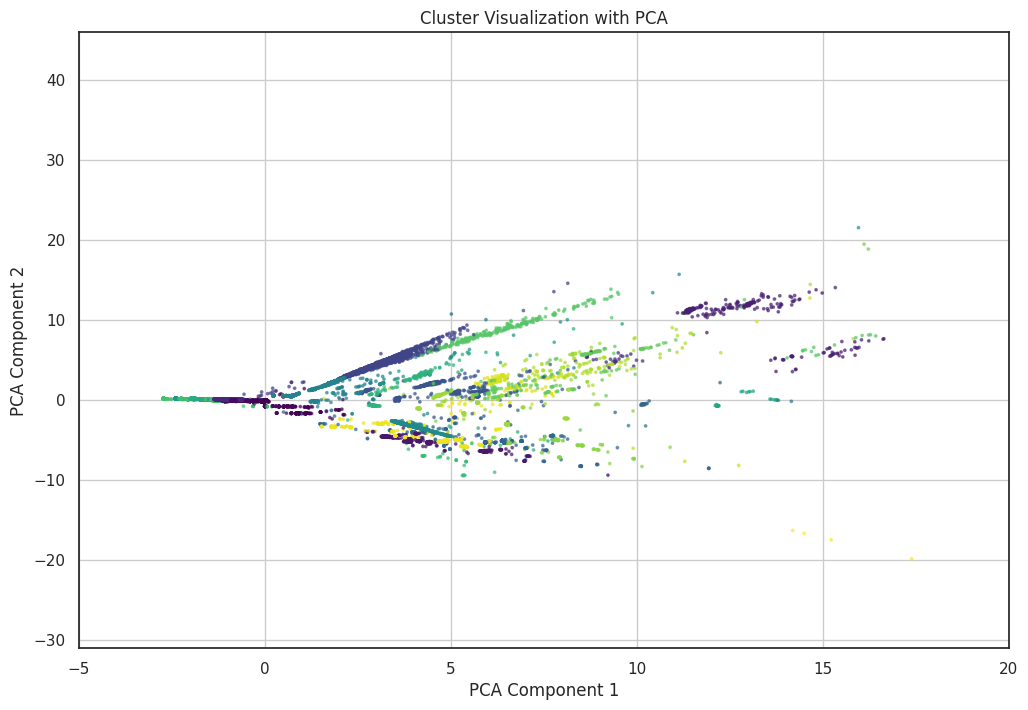

In [10]:
kmeans = KMeans(n_clusters=35, random_state=0)
cl_labels = kmeans.fit_predict(X_s)

centroids = kmeans.cluster_centers_

# Reducing the dimensionality of the dataset with PCA.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_s)

# Reducing the dimensionality of centroids with PCA.
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", best_n)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cl_labels, s=3, cmap='viridis', alpha=0.6)
#plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=10, alpha=0.75, edgecolors='black')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization with PCA')
plt.xlim(-5, 20)
plt.grid(True)
plt.show()


# **GMM**

## Determine the parameters of GMM

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


# Valutazione del modello per diversi numeri di cluster
n_clusters = range(10, 60, 3)
models = [GaussianMixture(n, init_params='kmeans', covariance_type='full', random_state=0).fit(X_s) for n in n_clusters]
aic = [m.aic(X_s) for m in models]
bic = [m.bic(X_s) for m in models]

# Trova il miglior numero di cluster basato su AIC e BIC
best_aic = n_clusters[np.argmin(aic)]
best_bic = n_clusters[np.argmin(bic)]

# Stampa dei migliori numeri di cluster
print(f"Best number of clusters according to AIC: {best_aic}")
print(f"Best number of clusters according to BIC: {best_bic}")

# Creazione del grafico
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, aic, label='AIC', marker='o')
plt.plot(n_clusters, bic, label='BIC', marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Value')
plt.title('Values of AIC and BIC for different cluster numbers')
plt.legend()
plt.grid(True)
plt.show()


best k:  77  with corresponding silhouette:  0.7075091057332417


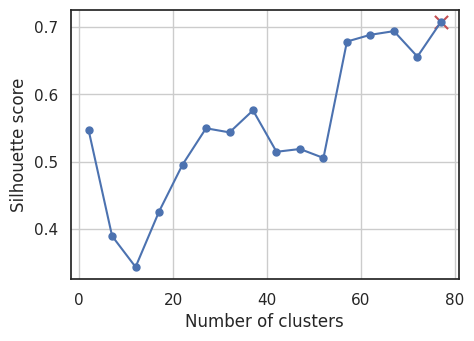

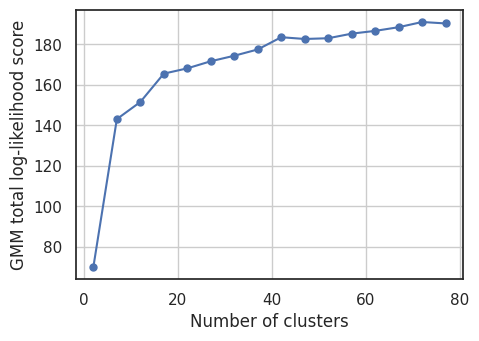

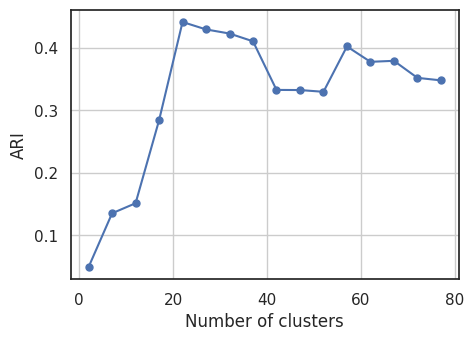

In [12]:
#GaussianMixture
#In this case use as hyper-parameter init_params = kmeans

#We computer the different scores for each iteration
n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
log_l_list=[]
for n_clusters in range(2, 80,5):
    gmm = GaussianMixture(n_clusters, init_params='kmeans', covariance_type='full', random_state=0)
    cl_labels = gmm.fit_predict(X_s)
    silhouette  = silhouette_score(X_s, cl_labels)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette)
    ri_list.append(rand_score(np.ravel(y), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(y), cl_labels))
    log_l_list.append(gmm.score(X_s))




# Get n_clusters leading to the highest silhouette
best_sh= np.max(shs_list)
best_n=n_cluster_list[np.argmax(shs_list)]
print("best k: ",best_n, " with corresponding silhouette: ", best_sh)


# Plot Silhouette
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,log_l_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()


## Applying GMM

In [13]:
gmm = GaussianMixture(30, init_params='kmeans', covariance_type='full', random_state=0)
gmm_labels = gmm.fit_predict(X_s)

# Calculate metrics (if you have original labels y)
silhouette = silhouette_score(X_s, gmm_labels)
ri = rand_score(np.ravel(y), gmm_labels)
ari = adjusted_rand_score(np.ravel(y), gmm_labels)

# Report the number and size of each cluster
(unique, counts) = np.unique(gmm_labels, return_counts=True)
print("Number of clusters: ", len(unique))
print("Size of each cluster: ", counts)

# Report unsupervised and supervised metrics
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

Number of clusters:  30

Size of each cluster:  [ 3425   237 17118  6196   489  2121  1121  6113    27   246   631  8313

    38     1   686  2043    53     1   183 11358   240    21   333     2

     2  1831   268     5    37  1100]

Silhouette: 0.55

RI: 0.88

ARI: 0.43


## ECDF of number of cluster

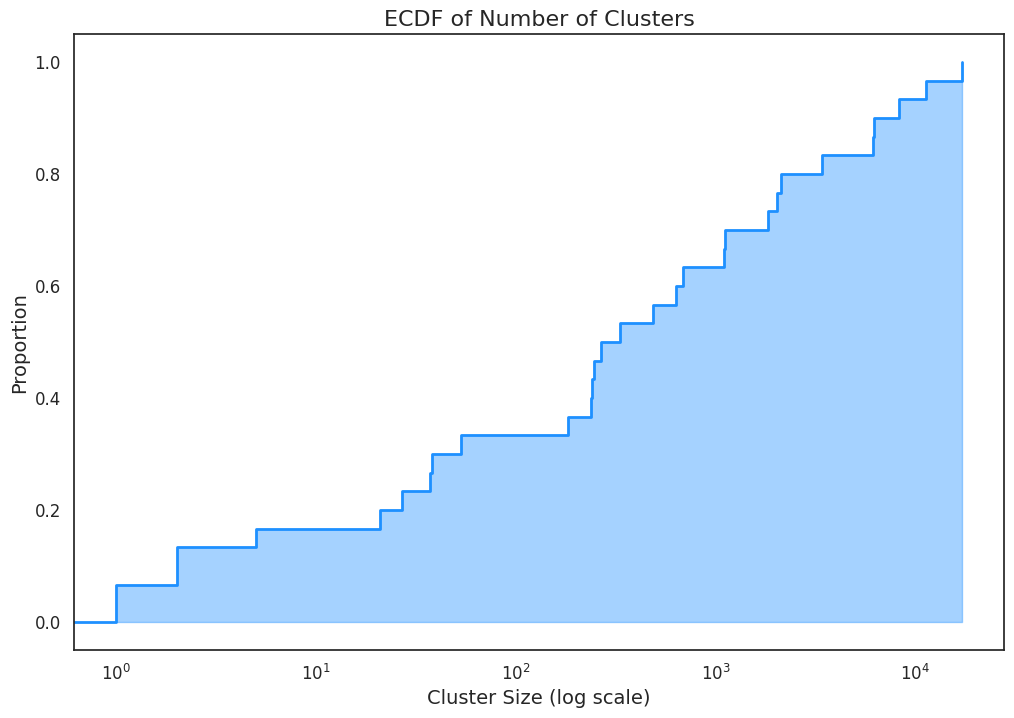

In [14]:
unique, counts = np.unique(gmm_labels, return_counts=True)
cluster_sizes = counts
ecdf = ECDF(cluster_sizes)

sns.set(style="white")
plt.figure(figsize=(12, 8))
plt.step(ecdf.x, ecdf.y, where="post", color='dodgerblue', linewidth=2)
plt.fill_between(ecdf.x, ecdf.y, step="post", alpha=0.4, color='dodgerblue')
plt.xscale('log')
plt.xlabel('Cluster Size (log scale)', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('ECDF of Number of Clusters', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## Cluster Visualization

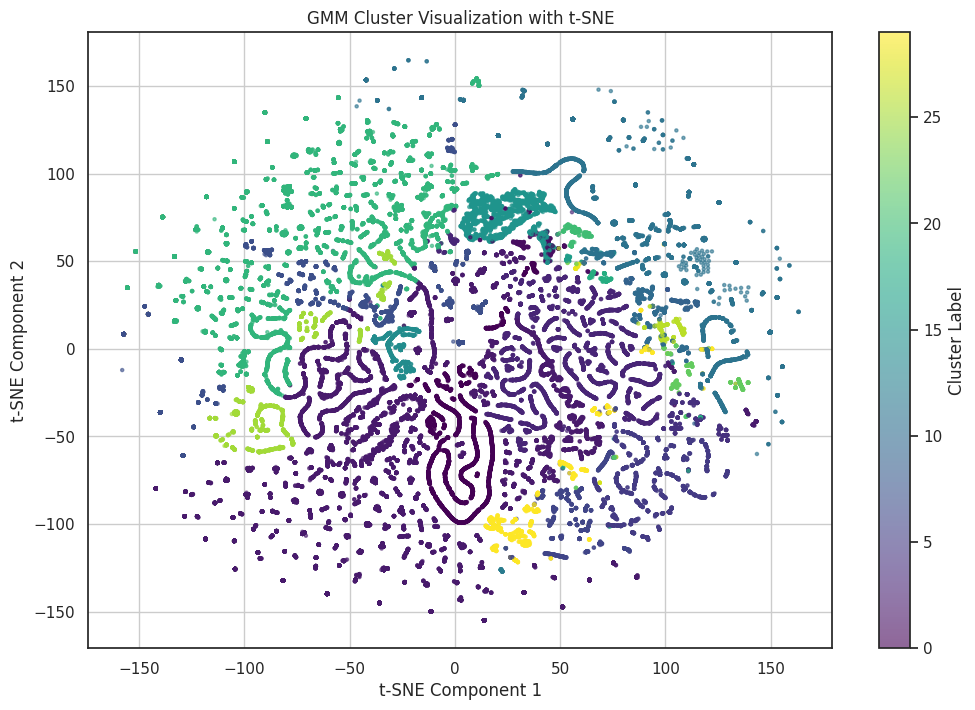

In [15]:

# Plot clusters in reduced space
plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", len(unique))  # Use a distinctive color palette

# Plotting points
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, s=5, cmap='viridis', alpha=0.6)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('GMM Cluster Visualization with t-SNE')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# **DBSCAN**

## Applying DBSCAN using default parameters

Number of clusters (including noise):  160

Size of each cluster:  [ 1943    27    91  2795    95    52   455   444     7    12     9     6

     5  2012    45    89    12    10   156    42   140   130    27    63

   151   517   103    12    20     5     7    29    18   117   177   285

    39    20     7    22   115     7    46    53    14    74    28     6

    12     5     6    41    19    17   804 17387    36    11    19     7

     6 16976    13     7    24   740   121   457    26    25    65    36

     9   104     7    16     8     8     5   103    37    65     7   115

     6     5    21     7     5  4124  1542   467    10   327   124    32

     5     8     9    46    13     8    10     7     5     5    25     6

    16    15     8    14     8     8     7     7     6     7     5     9

     6     6     6     5     5    26     7     8    15    16    20     5

     6     6     9     7     6     5     5     5     5     7     5     5

     5     5     8     8  1584  5236  1354   

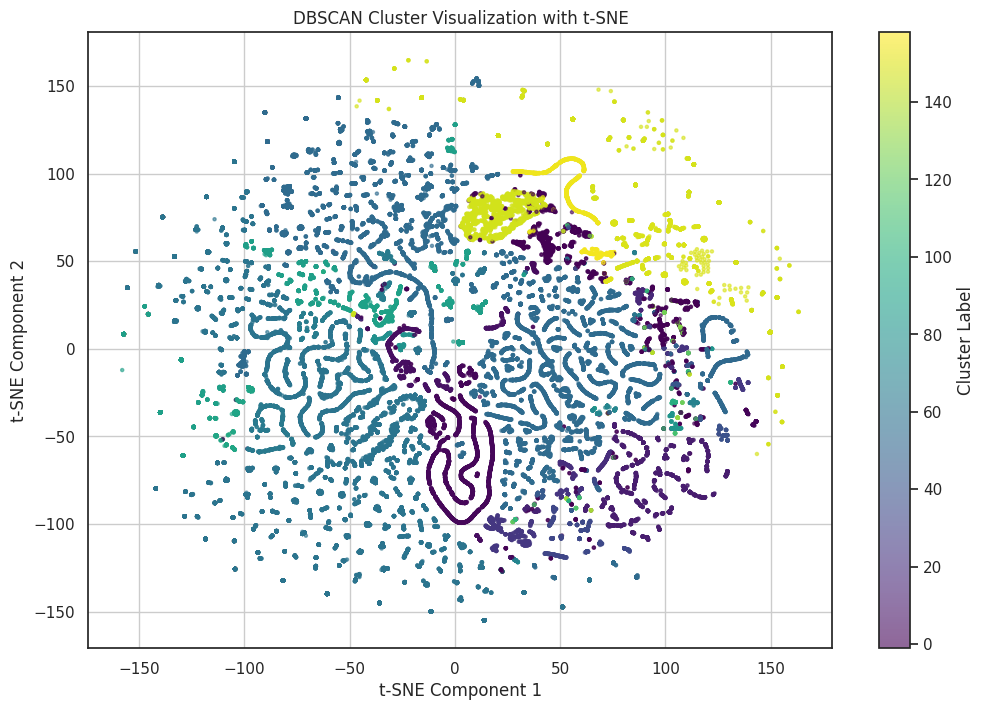

In [17]:
# Run DBSCAN with default parameters.
dbscan = DBSCAN()
cl_labels3 = dbscan.fit_predict(X_s)

silhouette = silhouette_score(X_s, cl_labels3)
ri = rand_score(np.ravel(y), cl_labels3)
ari = adjusted_rand_score(np.ravel(y), cl_labels3)

# Report the number and size of each cluster.
(unique, counts) = np.unique(cl_labels3, return_counts=True)
print("Number of clusters (including noise): ", len(unique))
print("Size of each cluster: ", counts)

print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", len(unique))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cl_labels3, s=5, cmap='viridis', alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('DBSCAN Cluster Visualization with t-SNE')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

## Determine best parameters of GMM

In [4]:
# Just to get a general idea
# Function to run DBSCAN and evaluate metrics.
def evaluate_dbscan(eps, min_samples, X_s, y):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cl_labels3 = dbscan.fit_predict(X_s)

    silhouette = silhouette_score(X_s, cl_labels3)
    ri = rand_score(np.ravel(y), cl_labels3)
    ari = adjusted_rand_score(np.ravel(y), cl_labels3)

    (unique, counts) = np.unique(cl_labels3, return_counts=True)
    print(f"eps: {eps}, min_samples: {min_samples}")
    print("Number of clusters (including noise): ", len(unique))
    print("Size of each cluster: ", counts)
    print(f'Silhouette: {round(silhouette, 2)}')
    print(f'RI: {round(ri, 2)}')
    print(f'ARI: {round(ari, 2)}')
    print('-'*40)

    return cl_labels3

# Tuning
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 20]

for eps in eps_values:
    for min_samples in min_samples_values:
        evaluate_dbscan(eps, min_samples, X_s, y)


eps: 0.3, min_samples: 5

Number of clusters (including noise):  225

Size of each cluster:  [ 3007    26    50  2576    84    52   129   292    22    35     7     7

     6     5  1050   584    10    31     5    70    16    24   140    45

    24     5    34   194   141    14   242    81     6     7     5   117

   128    52    15    13     5   111     9    42    22    39    43   156

   183    26    13    14    11     7    16    17     8     5     7     6

    12    79     5     7   604     9    70 10307    17    22  7037    29

     5     7 16976    13    14    25    37    12   649   105   295    12

     9     7    16    66    21    63    17    90    14    19     7    16

     5     7   225     5    16   184    11     5     6     5    58    65

     5     7     5   219    11     7     5    22   114     6     5     5

     8    71    44     6  4118  1541   467    10     6   326   123    32

     8    35    91     8    35    17     5    46     6     5    12     8

     7     7     7 

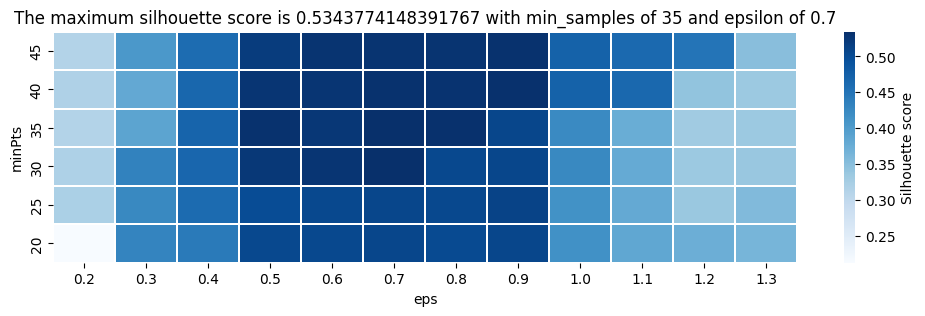

In [5]:
# analyze the performance varying epsilon and min_samples.
shs = []
for eps in np.arange(0.2, 1.4, 0.1):
    eps = round(eps,3)
    for mins in range(20, 50, 5):
        dbscan = DBSCAN(eps=eps, min_samples=mins)
        cl_labels3 = dbscan.fit_predict(X_s)
        try:
            silhouette  = silhouette_score(X_s, cl_labels3)
        except:
            silhouette = np.nan
        shs.append((eps, mins, silhouette))

gs = pd.DataFrame(shs, columns=['eps', 'minPts', 'sh'])
gs = pd.pivot_table(gs, columns='eps', index='minPts', values='sh', aggfunc=lambda x:x)

# Plot the silhouette score for the different values with a heatmap
plt.figure(figsize=(12,3))
max_ss = gs.max().max()
mins_max_ss = gs.stack().idxmax()[0]
eps_max_ss = gs.stack().idxmax()[1]
plt.title(f'The maximum silhouette score is {max_ss} with min_samples of {mins_max_ss} and epsilon of {eps_max_ss}')
sns.heatmap(gs, cmap='Blues', cbar_kws={'label':'Silhouette score'}, linewidths=.005)
plt.gca().invert_yaxis()
plt.show()

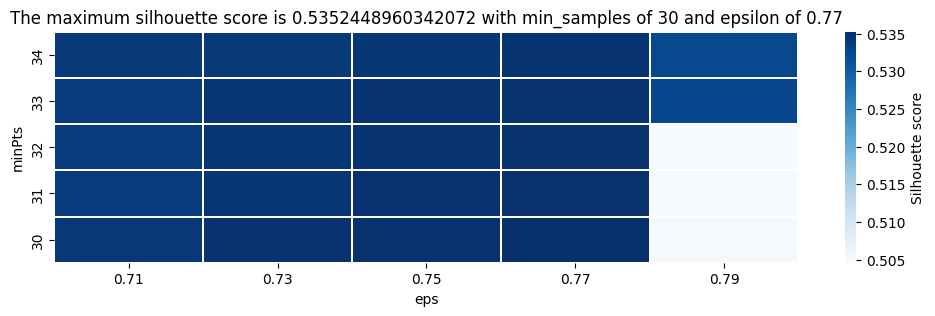

In [3]:
# analyze the performance varying epsilon and min_samples.
shs = []
for eps in np.arange(0.71, 0.8, 0.02):
    eps = round(eps,3)
    for mins in range(30, 35):
        dbscan = DBSCAN(eps=eps, min_samples=mins)
        cl_labels3 = dbscan.fit_predict(X_s)
        try:
            silhouette  = silhouette_score(X_s, cl_labels3)
        except:
            silhouette = np.nan
        shs.append((eps, mins, silhouette))

gs = pd.DataFrame(shs, columns=['eps', 'minPts', 'sh'])
gs = pd.pivot_table(gs, columns='eps', index='minPts', values='sh', aggfunc=lambda x:x)

# Plot the silhouette score for the different values with a heatmap
plt.figure(figsize=(12,3))
max_ss = gs.max().max()
mins_max_ss = gs.stack().idxmax()[0]
eps_max_ss = gs.stack().idxmax()[1]
plt.title(f'The maximum silhouette score is {max_ss} with min_samples of {mins_max_ss} and epsilon of {eps_max_ss}')
sns.heatmap(gs, cmap='Blues', cbar_kws={'label':'Silhouette score'}, linewidths=.005)
plt.gca().invert_yaxis()
plt.show()

## ECDF of number of cluster

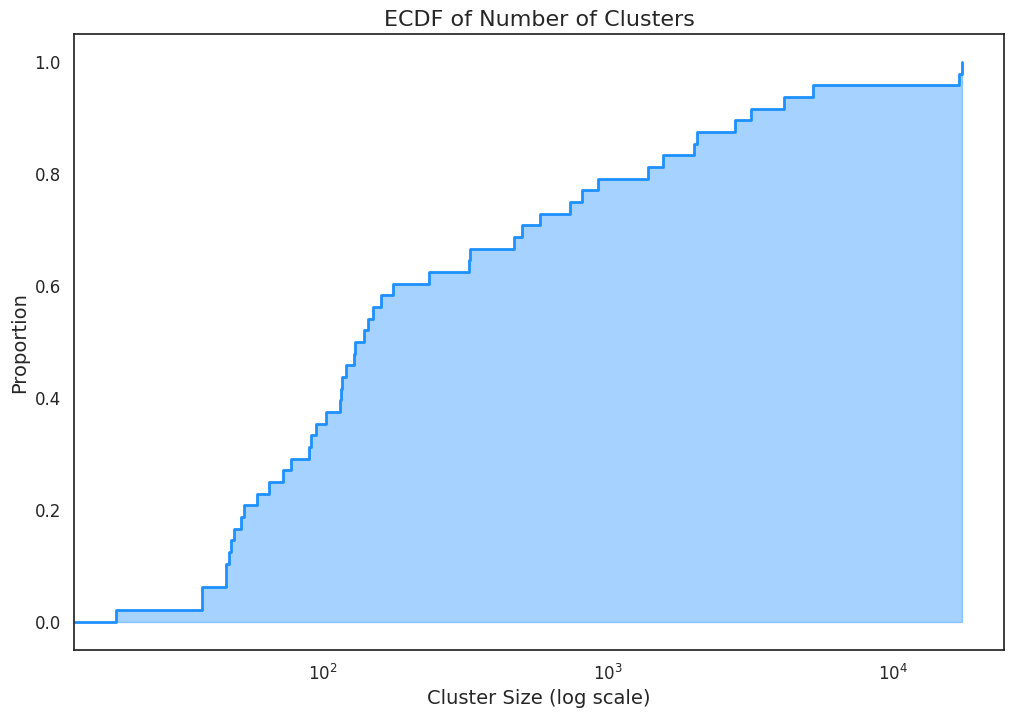

In [6]:
dbscan = DBSCAN(eps=0.77, min_samples=30)
cl_labels = dbscan.fit_predict(X_s)

unique, counts = np.unique(cl_labels, return_counts=True)
cluster_sizes = counts
ecdf = ECDF(cluster_sizes)

sns.set(style="white")
plt.figure(figsize=(12, 8))
plt.step(ecdf.x, ecdf.y, where="post", color='dodgerblue', linewidth=2)
plt.fill_between(ecdf.x, ecdf.y, step="post", alpha=0.4, color='dodgerblue')
plt.xscale('log')
plt.xlabel('Cluster Size (log scale)', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('ECDF of Number of Clusters', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## Cluster Visualization

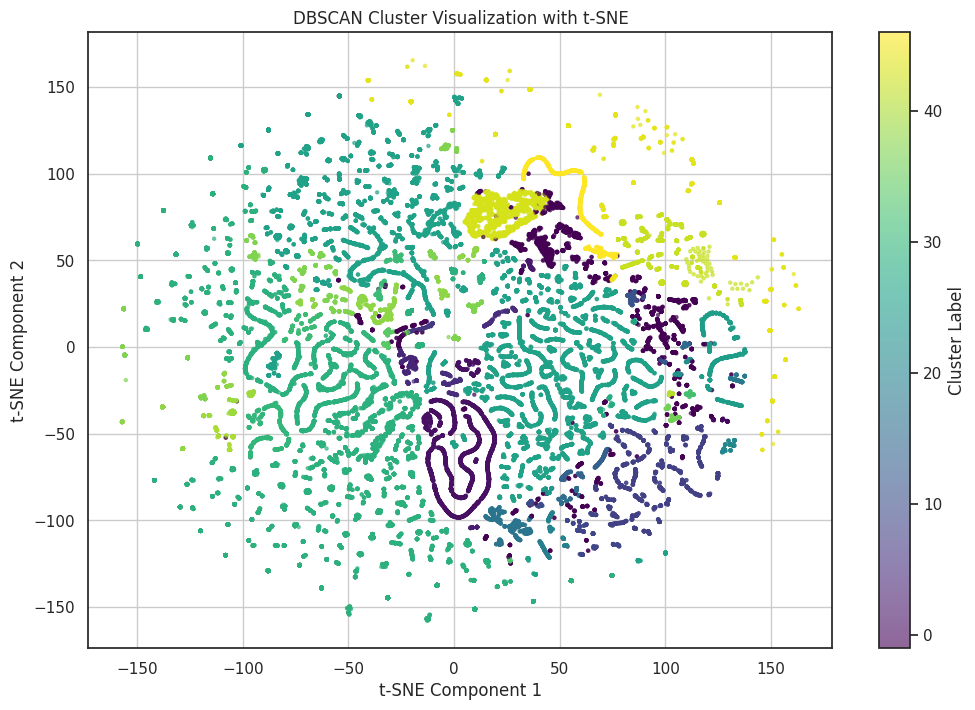

In [7]:
plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", len(unique))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cl_labels, s=5, cmap='viridis', alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('DBSCAN Cluster Visualization with t-SNE')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()